# Subthalamic Nucleus neuron
## Validation of the model implementation

### Imports

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from PySONIC.core import Batch, PointNeuron, NeuronalBilayerSonophore, PulsedProtocol, AcousticDrive
from PySONIC.neurons import OtsukaSTN
from PySONIC.utils import logger, si_format, pow10_format, Intensity2Pressure
from PySONIC.plt import CompTimeSeries, GroupedTimeSeries
from PySONIC.constants import *
from PySONIC.postpro import computeFRProfile

logger.setLevel(logging.INFO)

pneuron = OtsukaSTN()
ref_Vm0 = pneuron.Vm0

### Spontaneous spiking activity

The Otsuka paper predicts a spontaneous firing rate around 10 Hz. However, their corresponding figure shows a slightly smaller firing rate, around 6-7 Hz.

<img src="Otsuka/fig1A.png" alt="STN spontaneous firing" style="height: 200px;"/>

 30/01/2020 17:18:18: OtsukaSTN: simulation @ A = 0.00 A/m2, 0.0 s stim, 1.0 s offset


Firing rate: median = 4.82 Hz, last value = 4.86 Hz


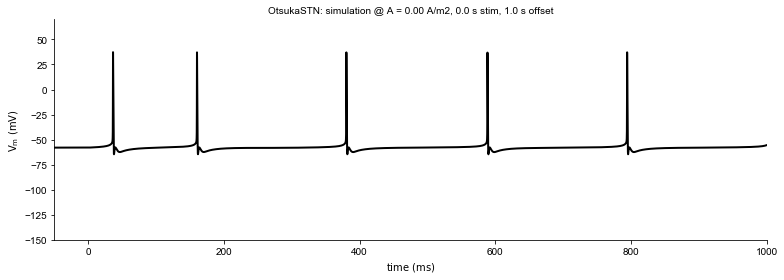

In [2]:
pp = PulsedProtocol(0., 1.)
data, meta = pneuron.simulate(0., pp)
fig = GroupedTimeSeries([(data, meta)], pltscheme={'V_m': ['Vm']}).render()[0]
sr = computeFRProfile(data)
sr = sr[~np.isnan(sr)]
print(f'Firing rate: median = {np.median(sr):.2f} Hz, last value = {sr[-1]:.2f} Hz')

Our simulations show a spontaneous firing stabilizing around 5 Hz. This is within the same order of magnitude as those reported in the Otsuka paper.  

### Response to depolarizing current pulses


The Otsuka paper predicts an increase in the neuron's firing rate from its spontaneous value upon intracellular injection of depolarizing current pulses at 0.5, 2 and 6 uA/cm2:

<img src="Otsuka/fig1D.png" alt="STN depolarizing pulses" style="height: 500px;"/>

In [3]:
def simPulses(pneuron, amps, pp):
    batch = Batch(lambda I: pneuron.simulate(I, pp), [[x] for x in amps])
    return batch(mpi=True, loglevel=logging.INFO)

I = 6.00 uA/cm2, firing rate: median = 93.31 Hz, last value = 91.32 Hz
I = 2.00 uA/cm2, firing rate: median = 50.96 Hz, last value = 50.00 Hz
I = 0.50 uA/cm2, firing rate: median = 25.21 Hz, last value = 25.16 Hz


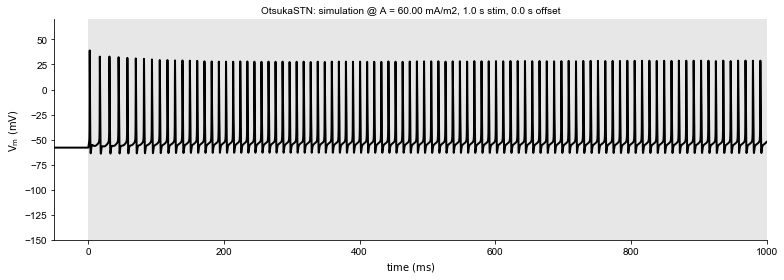

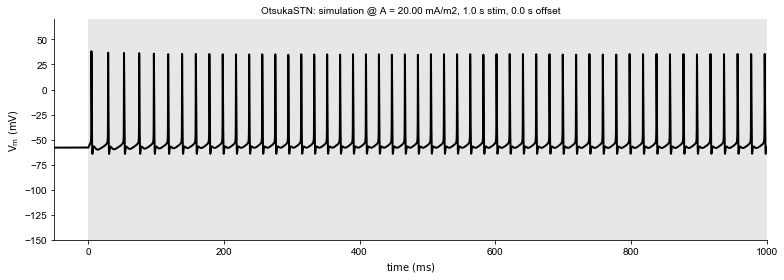

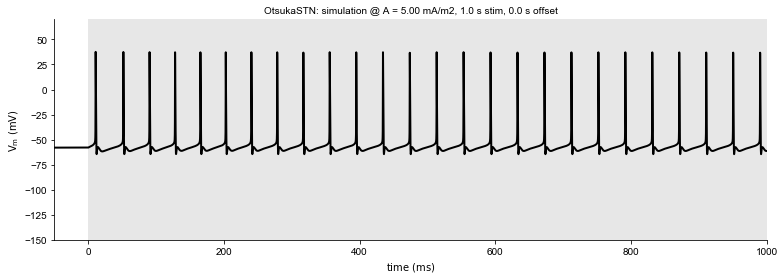

In [4]:
# Run simulations for characteristic currents
pp = PulsedProtocol(1., 0.)
ref_currents = [60., 20., 5.]  # mA/m2
outputs = simPulses(pneuron, ref_currents, pp)

# Plot Vm profiles
for I, out in zip(ref_currents, outputs):
    data, meta = out
    fig = GroupedTimeSeries([(data, meta)], pltscheme={'V_m': ['Vm']}).render()[0]    
    sr = computeFRProfile(data)
    sr = sr[~np.isnan(sr)]
    print(f'I = {(I * 1e-1):.2f} uA/cm2, firing rate: median = {np.median(sr):.2f} Hz, last value = {sr[-1]:.2f} Hz')

As we can see, the spike rates for the 3 characteristic currents seem accurately reproduced with our implementation.

More globally, the Otsuka paper predicts a quasi-linear increase in the neuron's firing rate with the stimulation amplitude:

<img src="Otsuka/fig1E.png" alt="STN FR vs amplitude" style="height: 200px;"/>

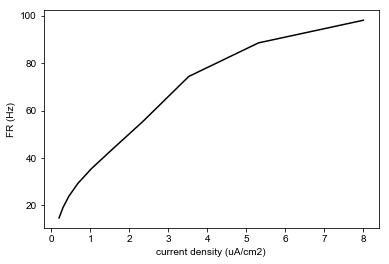

In [5]:
# Run simulations for various depolarizing pulses
currents = np.logspace(np.log10(2), np.log10(80), 10)  # mA/m2
outputs = simPulses(pneuron, currents, pp)

# Plot FR dependency on injected current
def plotFRvsCurrent(currents, sr):
    fig, ax = plt.subplots()
    ax.set_xlabel('current density (uA/cm2)')
    ax.set_ylabel('FR (Hz)')
    ax.plot(currents / 10, sr, c='k', markersize=4)
    return fig

sr_profiles = [computeFRProfile(out[0]) for out in outputs]
stab_sr = [sr[~np.isnan(sr)][-1] for sr in sr_profiles]
fig = plotFRvsCurrent(currents, stab_sr)

We obtain a similar dependency profile with our implementation.

### Generation of plateau potentials

The Otsuka paper predicts the induction of long-lasting plateau potentials inducing high-frequency spike bursts in response to small depolarizing pulses preceded by long hyperpolarizing pulses. Moreover, it predicts that the extent of the induced bursts heavily depends on the initial hyperpolarized voltage value:

<img src="Otsuka/fig3B.png" alt="STN plateau potential" style="height: 500px;"/>

Here, we simply re-initialize the STN neuron at a membrane potential lower than its resting potential, in order to mimick the effect of a hyperpolarizing current that would drive the membrane to a hyperpolarized state and hence suppress the neuron's spontaneous activity. Then, we inject a short depolarizing pulse (50 mA/m2, 50 ms, similarly as in Otsuka 2004), in order to elicit the plateau potential burst of spikes. 

Due to the current implementation, no hyperpolarizing current can be injected after the depolarizing pulse, hence the neuron's spontaneous activity can re-occur after the burst. 

In [2]:
def simPulseOffsets(pclass, Voffsets, I, pp):
    def simVoffset(Vm0):
        pclass.Vm0 = Vm0
        return pclass().simulate(I, pp)
    batch = Batch(simVoffset, [[x] for x in Voffsets])
    return batch(mpi=True, loglevel=logging.INFO)

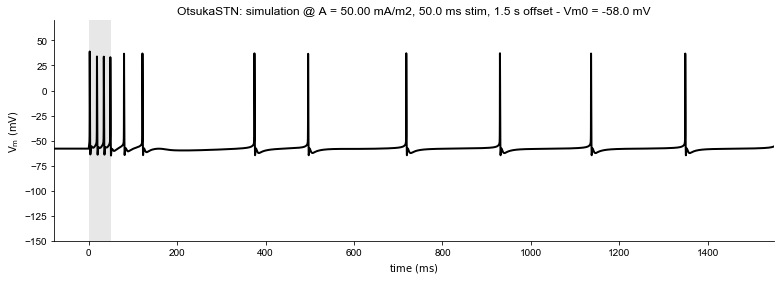

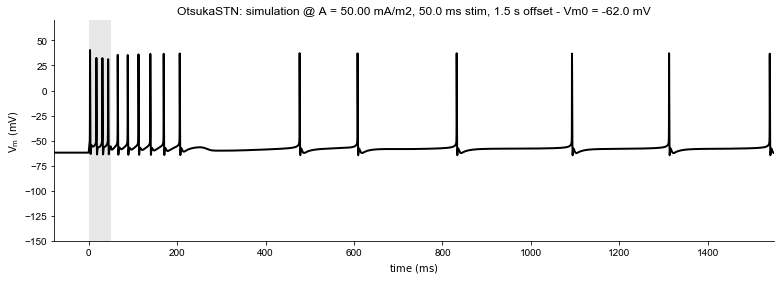

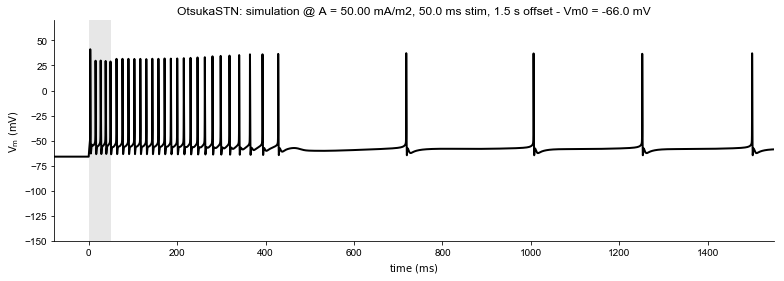

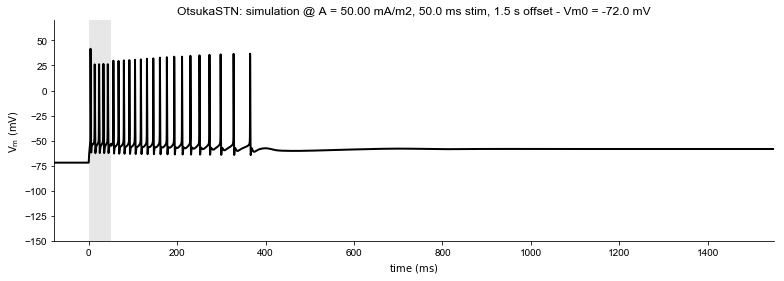

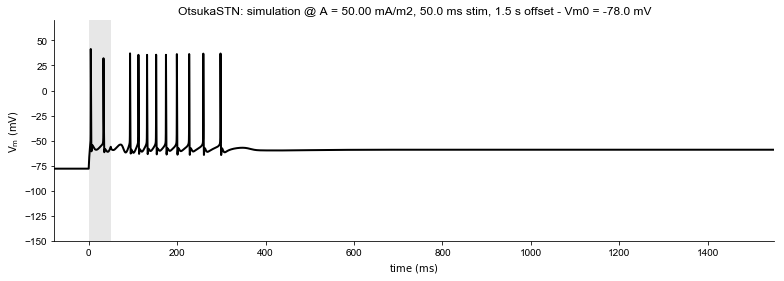

In [3]:
# Run simulations for various initial voltage offsets
pp = PulsedProtocol(50e-3, 1.5)
Voffsets = [-58., -62., -66., -72., -78.]  # mV
I = 50.  # mA/m2
outputs = simPulseOffsets(OtsukaSTN, Voffsets, I, pp)

# Plot Vm profiles
for Vm0, out in zip(Voffsets, outputs):
    data, meta = out
    fig = GroupedTimeSeries([(data, meta)], pltscheme={'V_m': ['Vm']}).render()[0]
    title = fig.get_axes()[0].get_title()
    fig.get_axes()[0].set_title(f'{title} - Vm0 = {Vm0} mV')

# Reset the neuron model
OtsukaSTN.Vm0 = ref_Vm0
pneuron = OtsukaSTN()
assert pneuron.Vm0 == ref_Vm0, f'Neuron resting potential should be set back to {ref_Vm0} mV'

Despite the slight difference of implementation, we still observe the presence of a burst of spikes that starts at the onset of the depolarizing pulse and then outlasts the stimulus duration.

We also notice that the duration of this burst seems to effectively depend on the initial value of membrane potential, with an optimum of approx. -70 mV at which the burst duration is maximal. This corroborates with the voltage-dependency of plateau potential generation observed in Otsuka 2004.

### Rebound bursting after hyperpolarizing pulses

The Otsuka paper predicts the induction of rebound plateau potentials with high-frequency spike bursts in response to hyperpolarizing pulses.

<img src="Otsuka/fig4D.png" alt="STN rebound potential" style="height:300px;"/>

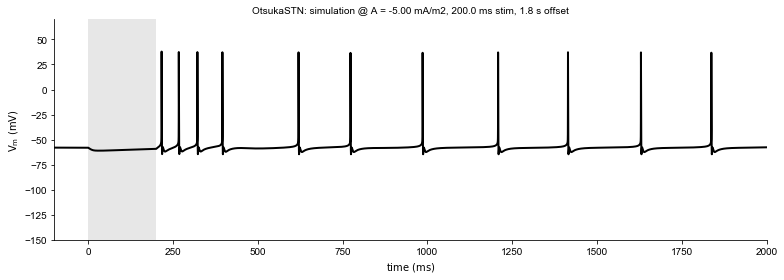

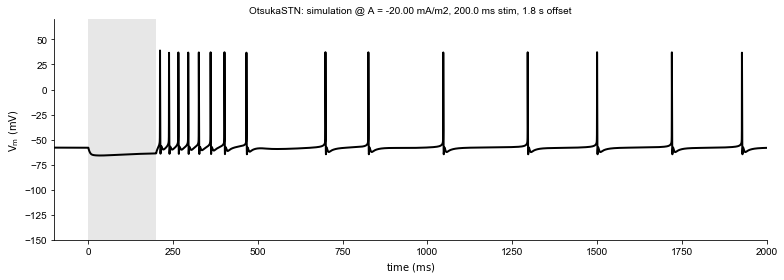

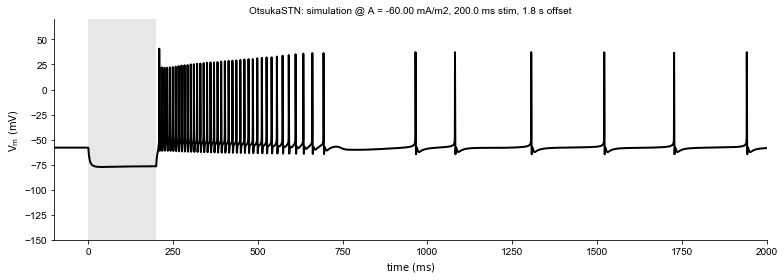

In [8]:
# Run simulations for various hyperpolarizing pulses
hyp_currents = [-5., -20., -60.]  # mA/m2
pp = PulsedProtocol(0.2, 1.8)
outputs = simPulses(pneuron, hyp_currents, pp)

# Plot Vm profiles
for I, out in zip(hyp_currents, outputs):
    data, meta = out
    fig = GroupedTimeSeries([(data, meta)], pltscheme={'V_m': ['Vm']}).render()[0]

We also observe the generation of rebound bursts at the offset of short hyperpolarizing pulses. Again, the burst spike rate and duration is dependent on the intensity of the hyperpolarizing pulse.

### Typical response to US CW stimulation

In [3]:
def simWaves(nbls, Fdrive, amps, pp):
    batch = Batch(lambda A: nbls.simulate(AcousticDrive(Fdrive, A), pp), [[x] for x in amps])
    return batch(mpi=True, loglevel=logging.INFO)

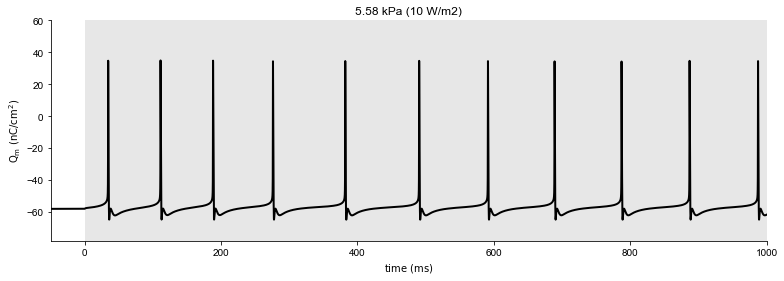

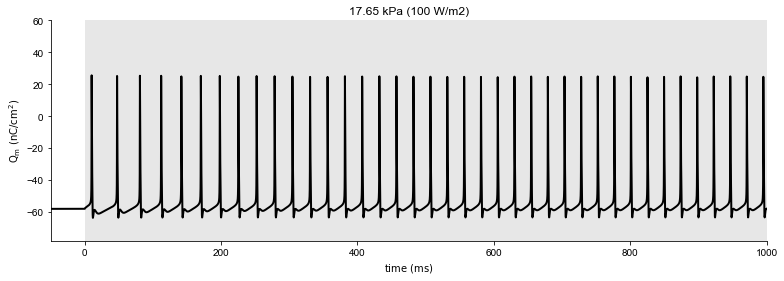

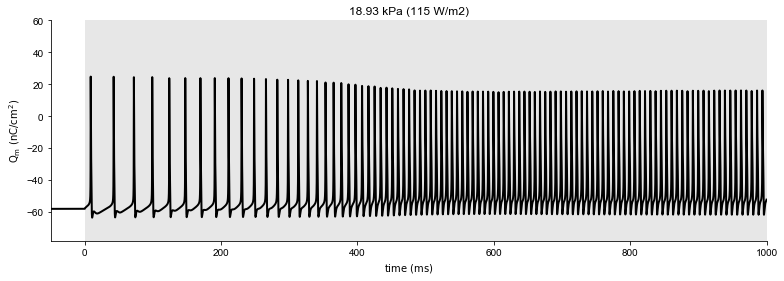

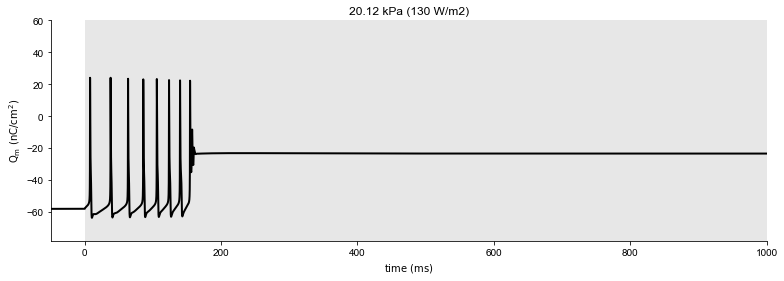

In [5]:
# Run simulations for various sonication intensities
a = 32e-9  # m
Fdrive = 500e3  # Hz
intensities = np.array([10., 100., 115., 130.])  # W/m2
amps = Intensity2Pressure(intensities, rho=1028.0)  # Pa
pp = PulsedProtocol(1., 0.0)
nbls = NeuronalBilayerSonophore(a, pneuron)
outputs = simWaves(nbls, Fdrive, amps, pp)

# Plot Qm profiles
for (I, A), out in zip(zip(intensities, amps), outputs):
    data, meta = out
    fig = GroupedTimeSeries([(data, meta)], pltscheme={'Q_m': ['Qm']}).render()[0]
    fig.axes[0].set_title(f'{A * 1e-3:.2f} kPa ({I:.0f} W/m2)')

We observe a transition between different spiking regimes as a function of acoustic intensity:
- for small intensities (10 to 100 W/m2), the acoustic stimulus simply excites the neuron at a constant firing rate, higher than its spontaneous physiological counterpart. Within this regime, increasing acoustic intensity simply raises the obtained firing rate.
- for intermediate intensities (115 W/m2), the acoustic stimulus triggers a neural response in which the firing pattern evolves in time, with spikes increasing in frequency and decrease in amplitude.
- for high intensities (130 W/m2), the acoustic stimulus triggers a few spikes and then a silenced plateau potential.

All those observations are qualitatively similar to those of Tarnaud 2018 for the same intensities:

<img src="Tarnaud/fig1A.png" alt="STN sonication FR profiles" style="height:300px;"/>

### Conclusions

Our implementation of the STN neuron model accurately reproduces neural responses upon application of both electrical and ultrasonic stimuli, as predicted by Otsuka 2004 and Tarnaud 2018

### References:

- Otsuka, T., Abe, T., Tsukagawa, T., and Song, W.-J. (2004). Conductance-Based Model of the Voltage-Dependent Generation of a Plateau Potential in Subthalamic Neurons. Journal of Neurophysiology 92, 255–264.
- Tarnaud, T., Joseph, W., Martens, L., and Tanghe, E. (2018). Computational Modeling of Ultrasonic Subthalamic Nucleus Stimulation. IEEE Trans Biomed Eng.